# Run GBAR Data Loader

This in an example notebook to get the GBAR data summary files and how to interact with them. The most up to date version is on the gitlab (https://gitlab.cern.ch/GBar/data-analysis-software).

In [1]:
import pandas as pd
from gbarDataLoader import loadLog, loadDatafile, loadVIS, loadShortSummary
from gbarVisualComparison import compareSwy, compareSwyDRS
from datetime import datetime
from time import mktime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tqdm import tqdm
loadVIS()

Enter the date you want to analyse the data. You can enter multiple dates after each other. Once you have selected the date press **ENTER** to stop.

You can get following files:
- Log: parameters of the GBAR experiment that were logged during the day
- ELENA: pbar intensity of ELENA and the SEM profiles
- Datafile: all of the ELENA files combined with the data files of GBAR
- ShortSummary: shortened summary of the Datafile (sufficient for most cases)

In [ ]:
date = 0
logFile = pd.DataFrame()
shortData = pd.DataFrame()
longData = pd.DataFrame()
while True:
    date2an = input('Enter measurement date [yy_mm_dd]: \n')
    if not date2an:
        break
    date = date2an
    log = loadLog(date2an)            
    logFile = pd.concat([logFile, log], axis=0)
    long = loadDatafile(date2an)
    longData = pd.concat([longData, long], axis=0)
    short = loadShortSummary(date2an)
    shortData = pd.concat([shortData, short], axis=0)

In [ ]:
shortData.shape

In [ ]:
shortData['st_rc3_ri']

You can check what the data you selected looks like in histograms.

In [ ]:
longData[{'SEM5020_gaussMean_horizontal', 'SEM5020_gaussMean_vertical',
          'SEM5060_gaussMean_horizontal', 'SEM5060_gaussMean_vertical',}].hist(bins=15, figsize=(15,15));

In [ ]:
t1 = input('Start time of interest: [hhmm] ')
t2 = input('End time of interest: [hhmm] ')

t1 = int(mktime(datetime(int('20'+date[0:2]),int(date[3:5]),int(date[6:8]), int(t1[0:2]), int(t1[2:4])).timetuple()))
t2 = int(mktime(datetime(int('20'+date[0:2]),int(date[3:5]),int(date[6:8]), int(t2[0:2]), int(t2[2:4])).timetuple()))

longData[(longData['Timestamp'] > t1) & (longData['Timestamp'] < t2)][{'SEM5020_gaussMean_horizontal', 'SEM5020_gaussMean_vertical',
          'SEM5060_gaussMean_horizontal', 'SEM5060_gaussMean_vertical'}].hist(figsize=(15,15));

In [ ]:
longData.plot.scatter(x='Datetime', y='SEM5020_gaussMean_horizontal'); plt.xticks(rotation=90);
longData.plot.scatter(x='Datetime', y='SEM5020_gaussMean_vertical'); plt.xticks(rotation=90);
longData.plot.scatter(x='Datetime', y='SEM5060_gaussMean_horizontal'); plt.xticks(rotation=90);
longData.plot.scatter(x='Datetime', y='SEM5060_gaussMean_vertical'); plt.xticks(rotation=90);

It is of interest to know when we took measurements with the MCP. Add or remove MCPs of interest in the next cell.

In [ ]:
time  =[datetime.fromtimestamp(entry) for entry in shortData['Timestamp']]
#mcp3 = [1 if pd.isna(entry) != True else None for entry in shortData['MCP3']]
#mcp5 = [1.1 if pd.isna(entry) != True else None for entry in shortData['MCP5']]
mcp6 = [1.2 if pd.isna(entry) != True else None for entry in shortData['MCP6']]
#mcp7 = [1.3 if pd.isna(entry) != True else None for entry in shortData['MCP7']]
wf = [-1.1 if pd.isna(entry) != True else None for entry in shortData['Waveform_12bit']]
drs = [1.4 if pd.isna(entry) != True else None for entry in shortData['DRS4']]

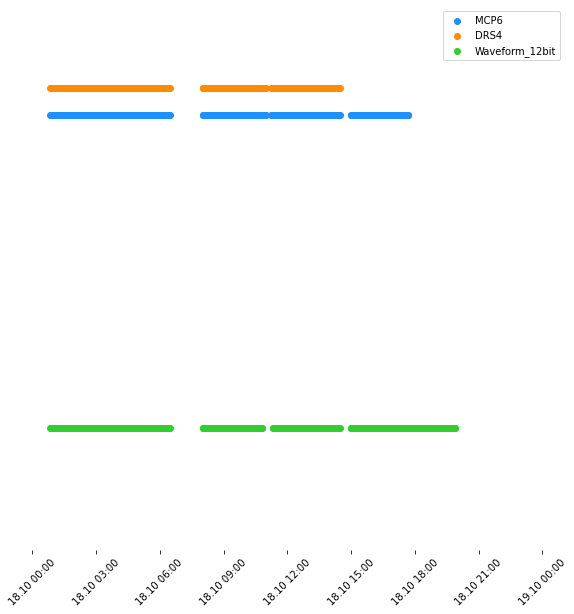

In [5]:
#%matplotlib ipympl
plt.figure(figsize=(10,10))
ax=plt.gca()
xfmt = mdates.DateFormatter('%d.%m %H:%M')
ax.xaxis.set_major_formatter(xfmt)
ax.axes.get_yaxis().set_visible(False)
#plt.scatter(time,mcp3, label='MCP3')
#plt.scatter(time,mcp5, label='MCP5')
plt.scatter(time,mcp6, label='MCP6', color='dodgerblue')
#plt.scatter(time,mcp7, label='MCP7')
plt.scatter(time,drs, label='DRS4', color='darkorange')
plt.scatter(time,wf, label='Waveform_12bit', color='limegreen')
plt.xticks(rotation=45) 
plt.legend(loc='best')
plt.ylim([-2,2])
plt.show()

You can compare the wavefrom with the corresponding MCP picture.

In [ ]:
day0 = input('Start day: [dd]')
day1 = input('End day: [dd]')
t1 = input('Start time of interest: [hhmm] ')
t2 = input('End time of interest: [hhmm] ')

t1 = int(mktime(datetime(int('20'+date[0:2]),int(date[3:5]),int(day0), int(t1[0:2]), int(t1[2:4])).timetuple()))
t2 = int(mktime(datetime(int('20'+date[0:2]),int(date[3:5]),int(day1), int(t2[0:2]), int(t2[2:4])).timetuple()))

selection = shortData[(shortData['Timestamp'] >= t1) & (shortData['Timestamp'] < t2)].reset_index()

In [3]:
for item in tqdm(range(selection.shape[0])):
    if selection['ELENA_Intensity'][item] > 5 and pd.isna(selection['DRS4'][item]) != True:
        timestamp = selection['Timestamp'][item]
        mcp6_file = selection['MCP6'][item]
        drs_file = selection['DRS4'][item]
        wf_file = selection['Waveform_12bit'][item]
        delay_PCO = selection['delay_C'][item]
        compareSwyDRS(timestamp,mcp6_file,wf_file, drs_file, delay_PCO)

NameError: name 'tqdm' is not defined

In [8]:
import seaborn as sns

/cvmfs/sft.cern.ch/lcg/views/LCG_100_nxcals/x86_64-centos7-gcc9-opt/lib/python3.8/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [23]:
%matplotlib ipympl
img = np.array(plt.imread(selection.MCP6[0])).astype(float)
ped_img = np.array(plt.imread("/eos/experiment/gbar/pgunpc/data/22_08_25/PCO-SwY_exp_1_us_1661434703.603.ped.tif")).astype(float)
img -= ped_img

print(img.min(), img.max(), img.mean())
plt.figure()
plt.imshow(img, cmap='vlag')
plt.colorbar()
plt.show()

-122.0 5157.0 -2.354972784040672


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

AttributeError: module 'matplotlib.pyplot' has no attribute 'heatmap'

In [20]:
from scipy.signal import find_peaks
from scipy import stats, optimize, integrate

In [16]:
df_peaks = pd.DataFrame()


In [24]:
for item in tqdm(range(selection.shape[0])):

    if selection['ELENA_Intensity'][item] > 5:
        timestamp = selection.Timestamp[item]
        file = selection.DRS4[item]

        if pd.isna(file) == False:
            drs = pd.read_csv(file, sep='\t')

            peaks1, properties1 = find_peaks(-drs.Channel1[100:], height=-0.15, distance=80)
            peaks2, properties2 = find_peaks(-drs.Channel2[100:], height=-0.15, distance=80)
            peaks3, properties3 = find_peaks(-drs.Channel3[100:], height=-0.15, distance=80)
            peaks4, properties4 = find_peaks(-drs.Channel4[100:], height=-0.15, distance=80)
            peaks5, properties5 = find_peaks(-drs.Channel5[100:], height=-0.15, distance=80)


            df1 = pd.DataFrame({'Peaks1':peaks1, 'Heights1':properties1['peak_heights']})
            df2 = pd.DataFrame({'Peaks2':peaks2, 'Heights2':properties2['peak_heights']})
            df3 = pd.DataFrame({'Peaks3':peaks3, 'Heights3':properties3['peak_heights']})
            df4 = pd.DataFrame({'Peaks4':peaks4, 'Heights4':properties4['peak_heights']})
            df5 = pd.DataFrame({'Peaks5':peaks5, 'Heights5':properties5['peak_heights']})

            size = max(df1.shape[0],df2.shape[0],df3.shape[0],df4.shape[0],df5.shape[0])
            time = [timestamp for i in range(size)]
            dft = pd.DataFrame({'Time': time})
            #df = pd.concat([dft,df1,df2,df3,df4,df5], axis=1)
            #print(df)
            df_peaks = pd.concat([df_peaks, pd.concat([dft,df1,df2,df3,df4,df5], axis=1)], ignore_index=True)

100%|██████████| 294/294 [00:04<00:00, 71.53it/s] 


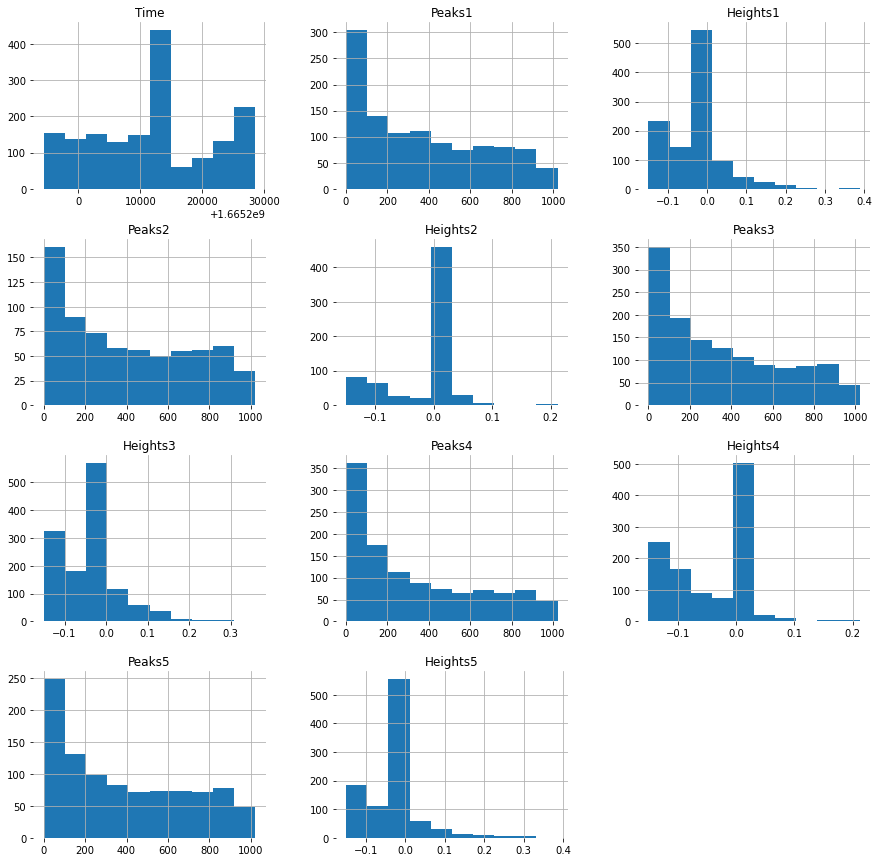

In [25]:
df_peaks.hist(figsize=(15,15));